In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import matplotlib.pylab as pl
from itertools import cycle
import matplotlib.gridspec as gridspec
import glob
import collections
import math
import re
import os
from collections import defaultdict

This notebook is used to plot the shannon calculations obtained from the multispecies_shannon_calculator code.

# NEED TO MODIFY THESE METHODS TO READ IN VALUES FOR SEVERAL DIFFERENT DATES

# ADD A RUN_ID OFFSET INTO THE JAVA CODE TO MAKE THINGS EASIER

# SO NEXT BATCH OF RUNS STARTS AT RUN_ID = 100 NOT 0

# CAN MAYBE JUST HAVE THE METHODS AS THEY ARE FOR THE MOST PART, AND ADD IN ANOTHER METHOD
# WHICH JOINS THE SHANNON DICTS TOGETHER BEFORE THEY'RE AVERAGED

In [34]:
def getEventCountersDataframe(date, pc_res, phase, sigma, duration):
    
    return pd.read_csv("geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date+"/"+str(pc_res)+"_resistant-"+date+"-event_counters-sigma="+"{:.5f}".format(sigma)+"-t="+str(duration)+".0.csv")


In [35]:
g_max = 0.083
nRuns = 100
nRuns_list = [r for r in range(nRuns)]
dates = ["24-Sep-2020", "09-Oct-2020"]
duration = 4368 #duration of sims in hours - equivalent to 26 weeks
pc_res_vals = [14, 15, 16] #percentages of the population which have an innante resistance to the biocide
phase2_str = "phase2"
log_norm_params_14pcRes = [2.703747953786337, 0.5690825284230452]
log_norm_params_15pcRes = [2.6133256846855746, 0.6260058161550592]
log_norm_params_16pcRes = [2.47772924764521, 0.7060073500033884]



#event counters dataframes
event_counters_14pc_24Sep = getEventCountersDataframe(dates[0], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_24Sep = getEventCountersDataframe(dates[0], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_24Sep = getEventCountersDataframe(dates[0], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_09Oct = getEventCountersDataframe(dates[1], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)


#paths to the directories containing all the processed shannon data csv files
shannon_directory_14pc_24Sep = "shannon_calculations_phase2/14_pc_res-24-Sep-2020/" 
shannon_directory_15pc_24Sep = "shannon_calculations_phase2/15_pc_res-24-Sep-2020/"

#paths to the directories containing the processed shannon data csv files for runs which exhibited GROWTH
shannon_directory_14pc_24Sep_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-24-Sep-2020/"
shannon_directory_15pc_24Sep_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-24-Sep-2020/"
shannon_directory_16pc_24Sep_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-24-Sep-2020/"

shannon_directory_14pc_09Oct_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-09-Oct-2020/"



#paths to the directories containing the processed shannon data csv files for runs which exhibited NOGROWTH
shannon_directory_14pc_24Sep_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-24-Sep-2020/"
shannon_directory_15pc_24Sep_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-24-Sep-2020/"
shannon_directory_16pc_24Sep_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-24-Sep-2020/"

shannon_directory_14pc_09Oct_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-09-Oct-2020/"


#paths to the directories containing the processed shannon data csv files for the EDGE microhabitats for runs which exhibited GROWTH
shannon_directory_14pc_24Sep_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-24-Sep-2020_GROWTH_EDGE/"
shannon_directory_15pc_24Sep_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-24-Sep-2020_GROWTH_EDGE/"
shannon_directory_16pc_24Sep_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-24-Sep-2020_GROWTH_EDGE/"

shannon_directory_14pc_09Oct_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-09-Oct-2020_GROWTH_EDGE/"


#lists of the runs which contain either growth or no growth
GROWTH_RUNS_14pc_24Sep = list(event_counters_14pc_24Sep["runID"][(event_counters_14pc_24Sep["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_24Sep = list(event_counters_15pc_24Sep["runID"][(event_counters_15pc_24Sep["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_24Sep = list(event_counters_16pc_24Sep["runID"][(event_counters_16pc_24Sep["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_09Oct = list(event_counters_14pc_09Oct["runID"][(event_counters_14pc_09Oct["bf_thickness"] > 0)])


NOGROWTH_RUNS_14pc_24Sep = list(event_counters_14pc_24Sep["runID"][~(event_counters_14pc_24Sep["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_24Sep = list(event_counters_15pc_24Sep["runID"][~(event_counters_15pc_24Sep["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_24Sep = list(event_counters_16pc_24Sep["runID"][~(event_counters_16pc_24Sep["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_09Oct = list(event_counters_14pc_09Oct["runID"][~(event_counters_14pc_09Oct["bf_thickness"] > 0)])

In [36]:
def combineShannonDataIntoDict(filepath, pc_res, nRuns):
    '''
    This iterates over all the csv files of the processed shannon data and collates them into a dictionary.
    
    The keys to this dictionary are the runIDs, the values in this dictionary are dataframes of the shannon data over time
    '''
    
    shannon_dict = {}
    
    for runID in nRuns:
        #the "/" is included in the filepath
        shannon_dict["runID_"+str(runID)] = pd.read_csv(filepath+"shannon_calculations-"+str(pc_res)+"_pc_res-runID_"+str(runID)+".csv")
        
    return shannon_dict

In [37]:
def collateShannonDicts(shannon_dict_list):
    '''
    this method takes in a list of the shannon dicts (the list contains dicts corresponding to the same pc_res, so all the 14% ones, or all the 15% ones, not a mixture)
    
    returns a "master" dict, containing all the shannon calculations for runs performed on different dates
    '''
    
    master_dict = shannon_dict_list[0].copy()
    
    for shannon_dict in shannon_dict_list[1:]:
        master_dict.update(shannon_dict)
        
    return master_dict

In [38]:
def getAveragedShannonVals(shannon_data):
    '''
    this method collates all the shannon data over all the runs and averages them
    '''
    time_df = pd.DataFrame() #time
    nBac_df = pd.DataFrame() #no. of bacteria over time
    H_df = pd.DataFrame() #shannon index over time
    E_df = pd.DataFrame() #shannon equitability over time
    S_df = pd.DataFrame() #no. of species over time
    
    for runID in shannon_data.keys():
        time_df[runID] = shannon_data[runID]["t"]
        nBac_df[runID] = shannon_data[runID]["nBac"]
        H_df[runID] = shannon_data[runID]["H"]
        E_df[runID] = shannon_data[runID]["E"]
        S_df[runID] = shannon_data[runID]["S"]
        
    t_avg = time_df.mean(axis=1)
    nBac_avg = nBac_df.mean(axis=1)
    H_avg = H_df.mean(axis=1)
    E_avg = E_df.mean(axis=1)
    S_avg = S_df.mean(axis=1)
    
    return np.array(t_avg), np.array(nBac_avg), np.array(H_avg), np.array(E_avg), np.array(S_avg)

In [39]:
def getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list):
    '''
    Rather than get the shannon data dicts, extract the lists of the data and then manually combine them into a list, eg 
    H1, _, _.. = getAveragedShannonVals(shannon_dict_1)
    H2, _, _.. = getAveragedShannonVals(shannon_dict_2)
    H_list = [H1, H2]
    
    This method takes in a list of the shannon dicts, and returns lists of the collated shannon variables - i.e returns H_list etc
    '''
    t_list = []
    nBac_list = []
    H_list = []
    E_list = []
    S_list = []
    
    for shannon_dict in shannon_data_dict_list:
        
        t, nBac, H, E, S = getAveragedShannonVals(shannon_dict)
        
        t_list.append(t)
        nBac_list.append(nBac)
        H_list.append(H)
        E_list.append(E)
        S_list.append(S)
        
    return t_list, nBac_list, H_list, E_list, S_list
        

In [40]:
#dicts where each entry is the shannon variables and the key is the runID
#all of the processed shannon data
#for when we have data from multiple dates, these dicts need to be combined into one master dict for each pc_res
#e.g. pc_res_14_24Sep_shannon_data_GROWTH + pc_res_14_16Oct_shannon_data_GROWTH = pc_res_14_shannon_data_GROWTH
pc_res_14_24Sep_shannon_data = combineShannonDataIntoDict(shannon_directory_14pc_24Sep, pc_res=14, nRuns=nRuns_list) 
pc_res_15_24Sep_shannon_data = combineShannonDataIntoDict(shannon_directory_15pc_24Sep, pc_res=15, nRuns=nRuns_list)

#GROWTH processed shannon data
#14%
pc_res_14_24Sep_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_24Sep_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_24Sep)
pc_res_14_09Oct_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_09Oct_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_09Oct)

pc_res_14_shannon_data_GROWTH_list = [pc_res_14_24Sep_shannon_data_GROWTH, pc_res_14_09Oct_shannon_data_GROWTH]

pc_res_14_shannon_data_GROWTH = collateShannonDicts(pc_res_14_shannon_data_GROWTH_list)
####################################################

pc_res_15_24Sep_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_24Sep_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_24Sep)
pc_res_16_24Sep_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_24Sep_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_24Sep)


#NOGROWTH processed shannon data
#14%
pc_res_14_24Sep_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_24Sep_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_24Sep)
pc_res_14_09Oct_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_09Oct_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_09Oct)

pc_res_14_shannon_data_NOGROWTH_list = [pc_res_14_24Sep_shannon_data_NOGROWTH, pc_res_14_09Oct_shannon_data_NOGROWTH]

pc_res_14_shannon_data_NOGROWTH = collateShannonDicts(pc_res_14_shannon_data_NOGROWTH_list)
###################################################################
pc_res_15_24Sep_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_24Sep_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_24Sep)
pc_res_16_24Sep_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_24Sep_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_24Sep)



#GROWTH processed shannon data for the EDGE microhabitats
#14%
pc_res_14_24Sep_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_24Sep_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_24Sep)
pc_res_14_09Oct_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_09Oct_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_09Oct)
pc_res_14_shannon_data_GROWTH_EDGE_list = [pc_res_14_24Sep_shannon_data_GROWTH_EDGE, pc_res_14_09Oct_shannon_data_GROWTH_EDGE]
pc_res_14_shannon_data_GROWTH_EDGE = collateShannonDicts(pc_res_14_shannon_data_GROWTH_EDGE_list)

pc_res_15_24Sep_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_24Sep_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_24Sep)
pc_res_16_24Sep_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_24Sep_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_24Sep)

In [41]:
shannon_data_dict_list = [pc_res_14_24Sep_shannon_data, pc_res_15_24Sep_shannon_data]
shannon_data_dict_list_GROWTH = [pc_res_14_shannon_data_GROWTH, pc_res_15_24Sep_shannon_data_GROWTH, pc_res_16_24Sep_shannon_data_GROWTH]
shannon_data_dict_list_NOGROWTH = [pc_res_14_shannon_data_NOGROWTH, pc_res_15_24Sep_shannon_data_NOGROWTH, pc_res_16_24Sep_shannon_data_NOGROWTH]
shannon_data_dict_list_GROWTH_EDGE = [pc_res_14_shannon_data_GROWTH_EDGE, pc_res_15_24Sep_shannon_data_GROWTH_EDGE, pc_res_16_24Sep_shannon_data_GROWTH_EDGE]

#for each of these lists, each element is the processed data for a different pc_res: i 0 = 14%, i 1 = 15% etc
t_list, nBac_list, H_list, E_list, S_list = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list)
t_list_GROWTH, nBac_list_GROWTH, H_list_GROWTH, E_list_GROWTH, S_list_GROWTH = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH)
t_list_NOGROWTH, nBac_list_NOGROWTH, H_list_NOGROWTH, E_list_NOGROWTH, S_list_NOGROWTH = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_NOGROWTH)
t_list_GROWTH_EDGE, nBac_list_GROWTH_EDGE, H_list_GROWTH_EDGE, E_list_GROWTH_EDGE, S_list_GROWTH_EDGE = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH_EDGE)

In [42]:
# t_14_pc_res_24Sep, nBac_14_pc_res_24Sep, H_14_pc_res_24Sep, E_14_pc_res_24Sep, S_14_pc_res_24Sep = getAveragedShannonVals(pc_res_14_24Sep_shannon_data)
# t_15_pc_res_24Sep, nBac_15_pc_res_24Sep, H_15_pc_res_24Sep, E_15_pc_res_24Sep, S_15_pc_res_24Sep = getAveragedShannonVals(pc_res_15_24Sep_shannon_data)

In [43]:
def plotPhaseComparisons(x_data_list, y_data_list, pc_res_vals, x_label, y_label, title_string, filename):
    plt.figure(figsize=(8,6))
    
    #n
    p1_colour = "#00b359"
    p2_colour = "#b800e6"
    p3_colour = "k"
    colour_list = [p1_colour, p2_colour, p3_colour]
    
    line_width = 6.
    p4_line_style = "--"
    #skip the first value as it's t=0 so there's only like 1 bacteria in there
    for x_data, y_data, pc_res_val, colour_val in zip(x_data_list, y_data_list, pc_res_vals, colour_list):
        plt.plot(x_data[2:], y_data[2:], label=str(pc_res_val)+"% resistant", lw=line_width, color=colour_val)
    
    
#     if time_bool:
#         plt.plot(x_p2[x_p2 <=100.][1:]*g_max, y_p2[x_p2 <=100.][1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} > 1$", lw=line_width, color=p2_color)
#         plt.plot(x_p4[x_p4 <=100.][1:]*g_max, y_p4[x_p4 <=100.][1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} < 1$", lw=line_width, color=p4_color, ls=p4_line_style)

#     else:
#         plt.plot(x_p2[1:], y_p2[1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} > 1$", lw=line_width, color=p2_color)
#         plt.plot(x_p4[1:], y_p4[1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} < 1$", lw=line_width, color=p4_color, ls=p4_line_style)
        
        
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.title(title_string, fontsize=20)
    #plt.semilogy()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=16)
    plt.locator_params(axis='x', nbins=4)
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    #plt.locator_params(axis='y', nbins=6)
    plt.savefig("shannon_calc_plots/"+filename, bbox_inches="tight")
    plt.show()

In [48]:
# plotPhaseComparisons(t_list, H_list, pc_res_vals, x_label="t", y_label="H", title_string="H vs t", filename="H_vs_t.pdf")
# plotPhaseComparisons(t_list, E_list, pc_res_vals, x_label="t", y_label="E", title_string="E vs t", filename="E_vs_t.pdf")
# plotPhaseComparisons(t_list, S_list, pc_res_vals, x_label="t", y_label="S", title_string="S vs t", filename="S_vs_t.pdf")
# plotPhaseComparisons(t_list, nBac_list, pc_res_vals, x_label="t", y_label="N", title_string="N vs t", filename="N_vs_t.pdf")

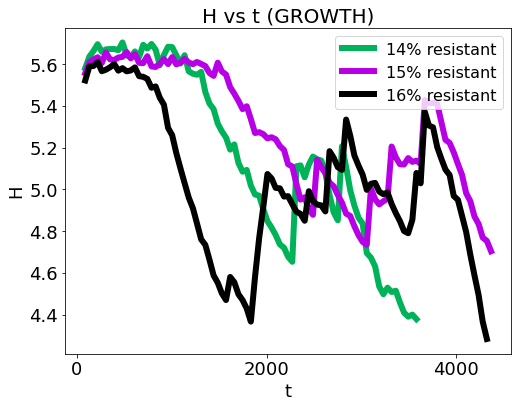

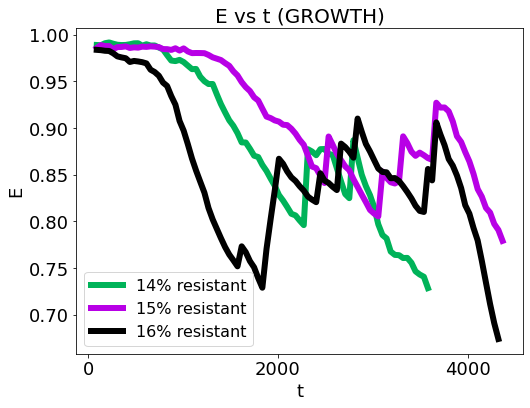

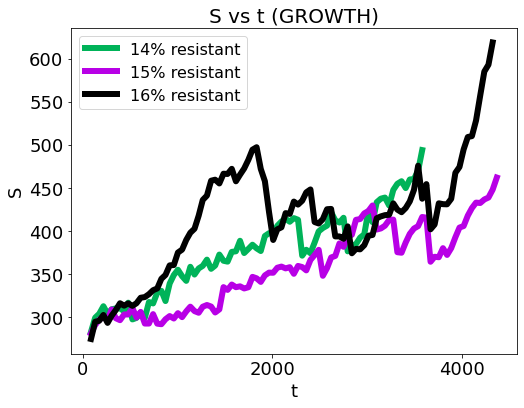

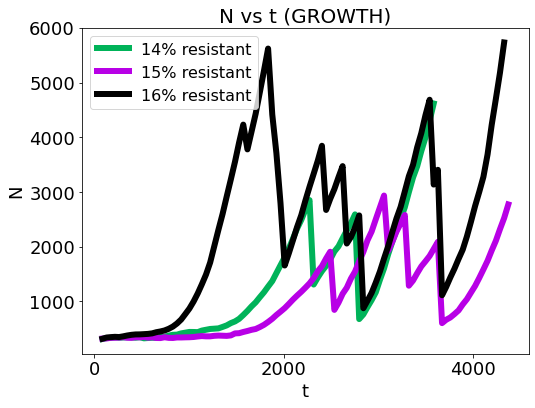

In [49]:
plotPhaseComparisons(t_list_GROWTH, H_list_GROWTH, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH)", filename="H_vs_t_GROWTH.pdf")
plotPhaseComparisons(t_list_GROWTH, E_list_GROWTH, pc_res_vals, x_label="t", y_label="E", title_string="E vs t (GROWTH)", filename="E_vs_t_GROWTH.pdf")
plotPhaseComparisons(t_list_GROWTH, S_list_GROWTH, pc_res_vals, x_label="t", y_label="S", title_string="S vs t (GROWTH)", filename="S_vs_t_GROWTH.pdf")
plotPhaseComparisons(t_list_GROWTH, nBac_list_GROWTH, pc_res_vals, x_label="t", y_label="N", title_string="N vs t (GROWTH)", filename="N_vs_t_GROWTH.pdf")

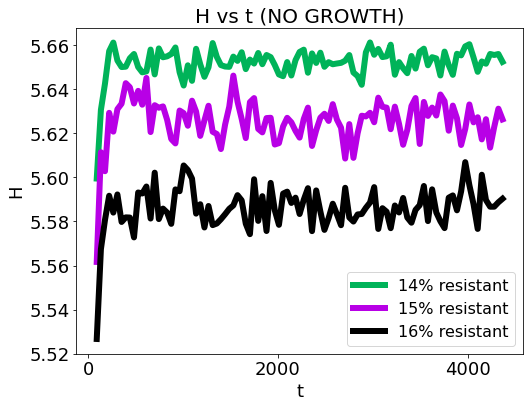

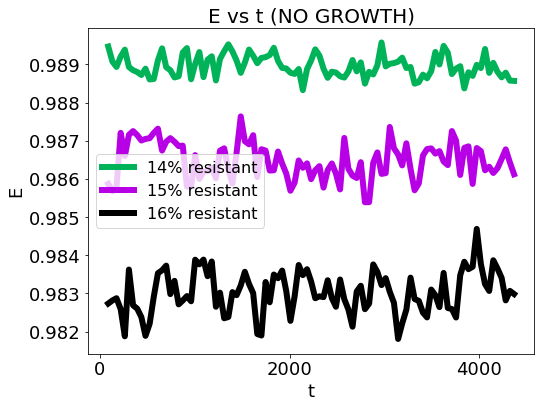

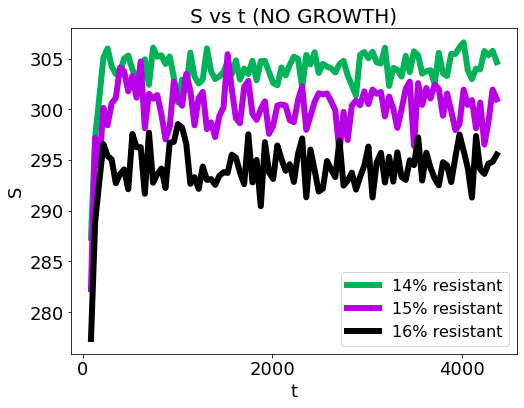

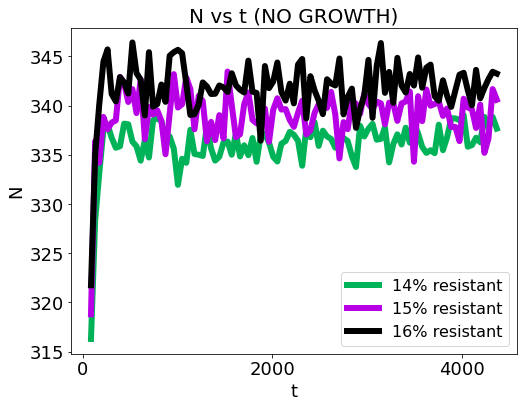

In [46]:
plotPhaseComparisons(t_list_NOGROWTH, H_list_NOGROWTH, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (NO GROWTH)", filename="H_vs_t_NOGROWTH.pdf")
plotPhaseComparisons(t_list_NOGROWTH, E_list_NOGROWTH, pc_res_vals, x_label="t", y_label="E", title_string="E vs t (NO GROWTH)", filename="E_vs_t_NOGROWTH.pdf")
plotPhaseComparisons(t_list_NOGROWTH, S_list_NOGROWTH, pc_res_vals, x_label="t", y_label="S", title_string="S vs t (NO GROWTH)", filename="S_vs_t_NOGROWTH.pdf")
plotPhaseComparisons(t_list_NOGROWTH, nBac_list_NOGROWTH, pc_res_vals, x_label="t", y_label="N", title_string="N vs t (NO GROWTH)", filename="N_vs_t_NOGROWTH.pdf")

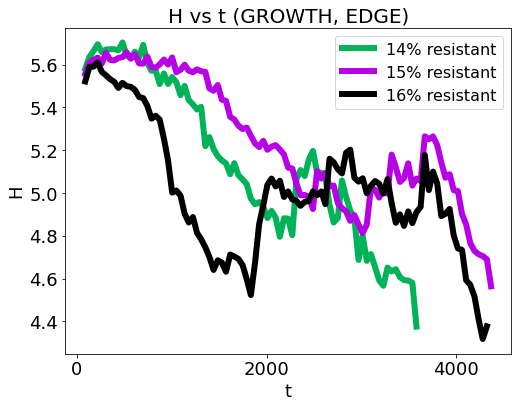

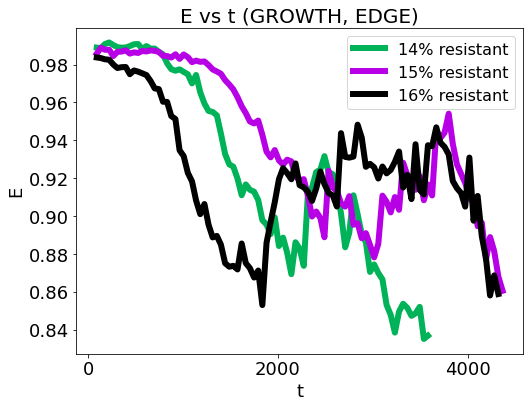

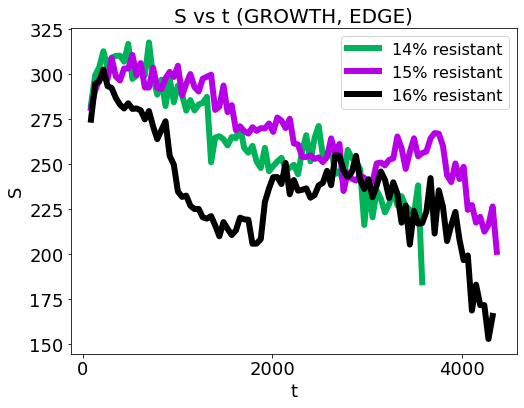

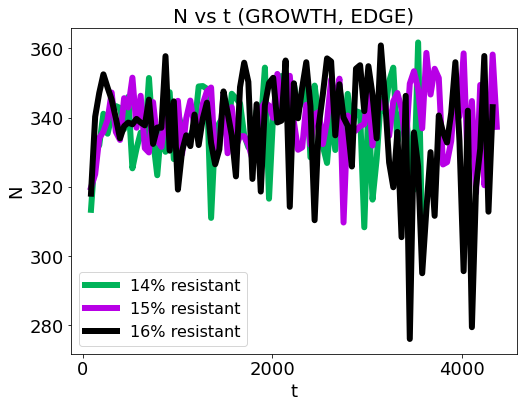

In [47]:
plotPhaseComparisons(t_list_GROWTH_EDGE, H_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH, EDGE)", filename="H_vs_t_GROWTH_EDGE.pdf")
plotPhaseComparisons(t_list_GROWTH_EDGE, E_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="E", title_string="E vs t (GROWTH, EDGE)", filename="E_vs_t_GROWTH_EDGE.pdf")
plotPhaseComparisons(t_list_GROWTH_EDGE, S_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="S", title_string="S vs t (GROWTH, EDGE)", filename="S_vs_t_GROWTH_EDGE.pdf")
plotPhaseComparisons(t_list_GROWTH_EDGE, nBac_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="N", title_string="N vs t (GROWTH, EDGE)", filename="N_vs_t_GROWTH_EDGE.pdf")

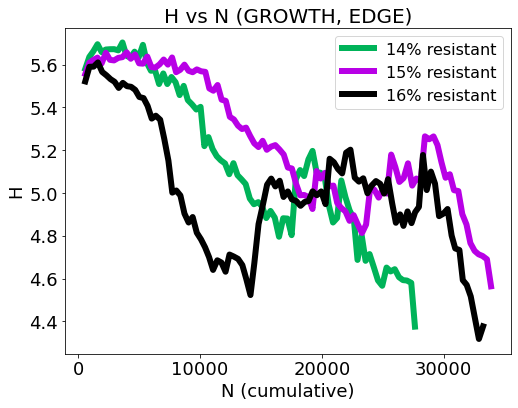

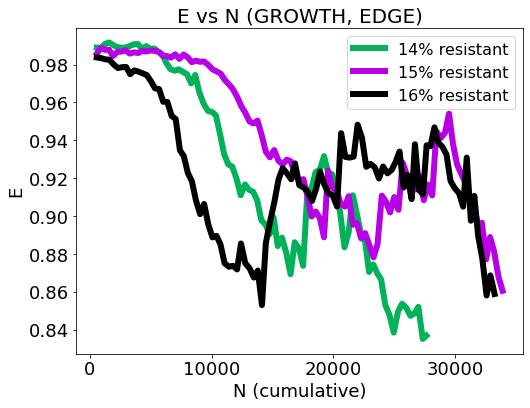

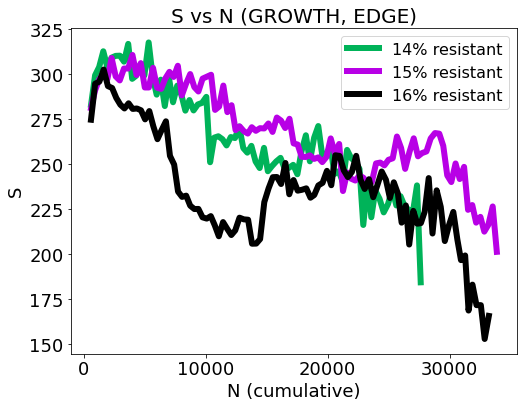

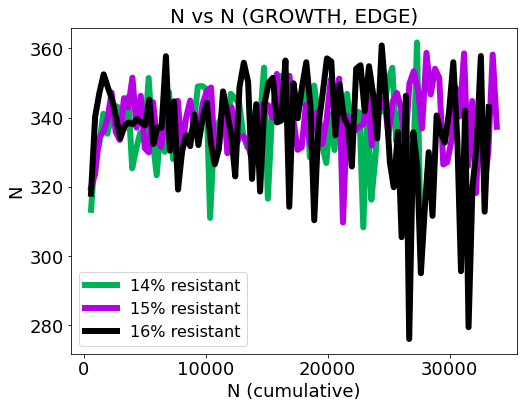

In [52]:
N_x_list = [np.cumsum(np.array(n)) for n in nBac_list_GROWTH_EDGE]
plotPhaseComparisons(N_x_list, H_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="H", title_string="H vs N (GROWTH, EDGE)", filename="H_vs_N_GROWTH_EDGE.pdf")
plotPhaseComparisons(N_x_list, E_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="E", title_string="E vs N (GROWTH, EDGE)", filename="E_vs_N_GROWTH_EDGE.pdf")
plotPhaseComparisons(N_x_list, S_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="S", title_string="S vs N (GROWTH, EDGE)", filename="S_vs_N_GROWTH_EDGE.pdf")
plotPhaseComparisons(N_x_list, nBac_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="N", title_string="N vs N (GROWTH, EDGE)", filename="N_vs_N_GROWTH_EDGE.pdf")

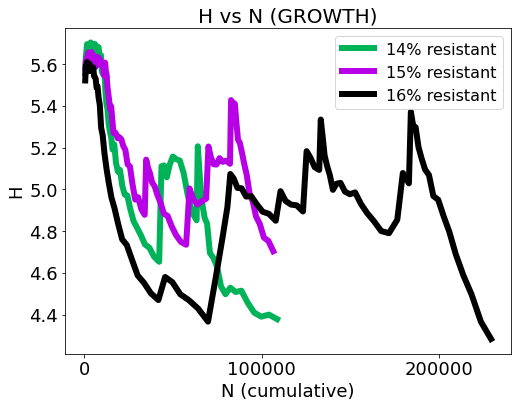

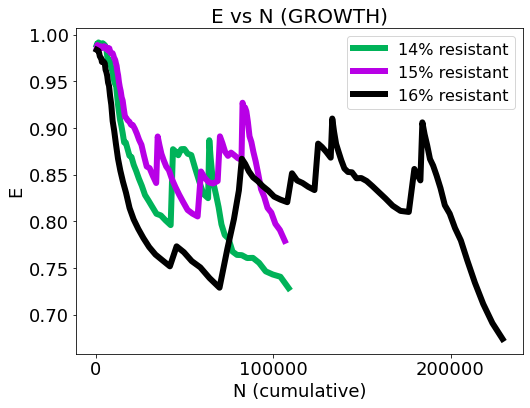

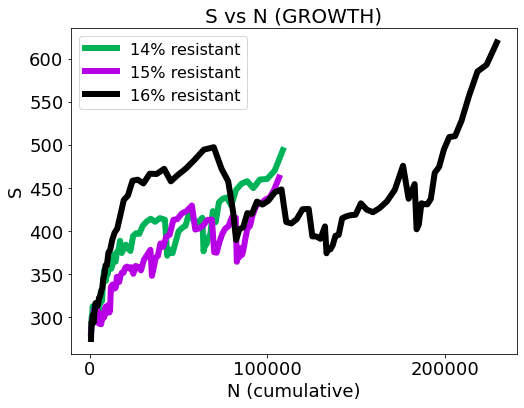

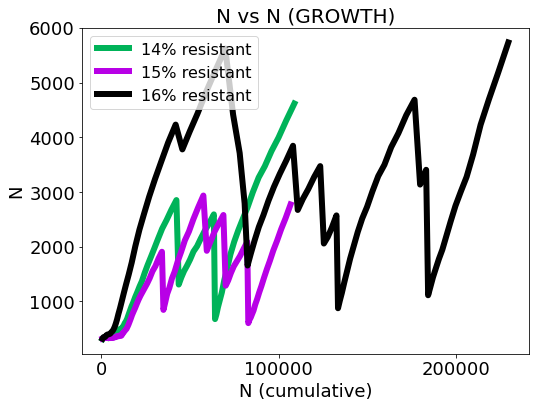

In [53]:
N_x_list = [np.cumsum(np.array(n)) for n in nBac_list_GROWTH]
plotPhaseComparisons(N_x_list, H_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="H", title_string="H vs N (GROWTH)", filename="H_vs_N_GROWTH.pdf")
plotPhaseComparisons(N_x_list, E_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="E", title_string="E vs N (GROWTH)", filename="E_vs_N_GROWTH.pdf")
plotPhaseComparisons(N_x_list, S_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="S", title_string="S vs N (GROWTH)", filename="S_vs_N_GROWTH.pdf")
plotPhaseComparisons(N_x_list, nBac_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="N", title_string="N vs N (GROWTH)", filename="N_vs_N_GROWTH.pdf")